In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
candidates = pd.read_csv('../data/candidates.csv') # refactor to explicitly set district as string

candidates.head()

,state_name,district,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent
0,AL,1,Jerry Carl,R,not incumbent,1,64.9,1971321,1859349
1,AL,1,James Averhart,D,not incumbent,0,35.0,80095,78973
2,AL,2,Barry Moore,R,not incumbent,1,65.3,650807,669368
3,AL,2,Phyllis Harvey-Hall,D,not incumbent,0,34.6,56050,55988
4,AL,3,Mike D Rogers,R,Incumbent,1,67.5,1193111,1218564


# when refactoring code, add state and district concat here to make life easier

In [30]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state_name      892 non-null    object 
 1   district        892 non-null    int64  
 2   candidate_name  892 non-null    object 
 3   party           892 non-null    object 
 4   incumbent       892 non-null    object 
 5   winner          892 non-null    int64  
 6   perc_vote       892 non-null    float64
 7   money_raised    892 non-null    int64  
 8   money_spent     892 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 62.8+ KB


In [31]:
candidates['party'].value_counts()

D    423
R    387
I     46
L     21
3     15
Name: party, dtype: int64

In [38]:
candidates.loc[(candidates['party'].isin(['I', 'L', '3'])) & (candidates['winner'] == 1)]

# no independent or 3rd party candidate won a race

,state_name,district,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent,max_raised,max_spent


### how many races didn't have an incumbant running? How does that correlate with number of candidates in the race?

### How often does the candidate who raised more money win a race?

Partition by state and district, sort by money_raised, qualify row_num = 1 (to only have the person from each race who raised the most money). Chart value_counts of winner column.

In [39]:
# new column with max raised in each district race
candidates['max_raised'] = candidates.groupby(['state_name', 'district'])['money_raised'].transform('max')

In [40]:
raised_winner = candidates.loc[candidates['money_raised'] == candidates['max_raised']]

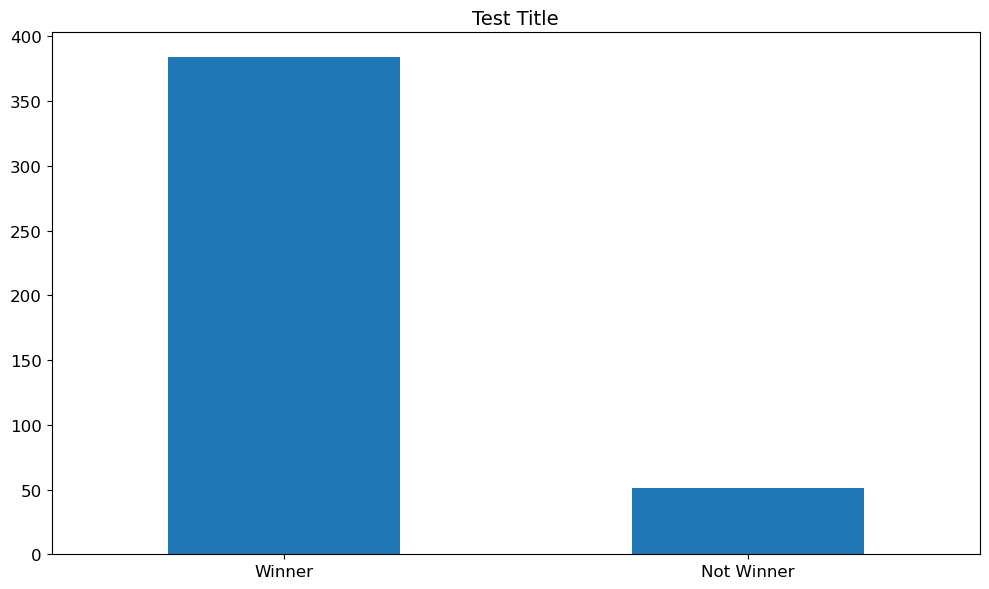

In [74]:
fontsize = 14

plt.figure(figsize = (10,6))
raised_winner['winner'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 0, labels = ['Winner', 'Not Winner'], ticks = [0, 1], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('Test Title', fontsize = fontsize + 2, )
plt.tight_layout()
plt.savefig('../data/test.png', dpi = 150);

#### How often does the candidate who spent more money win a race?

Same strategy as previous question.

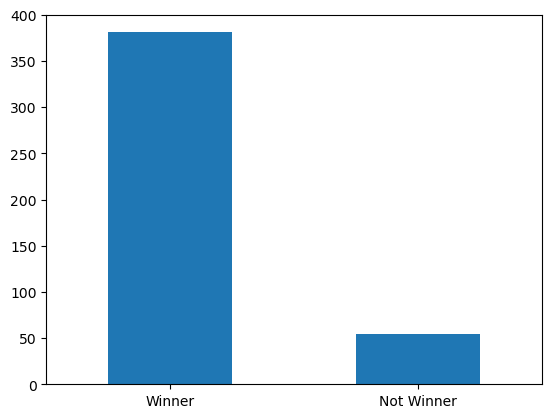

In [69]:
# new column with max spent in each district race
candidates['max_spent'] = candidates.groupby(['state_name', 'district'])['money_spent'].transform('max')

spent_winner = candidates.loc[candidates['money_spent'] == candidates['max_spent']]

spent_winner['winner'].value_counts().plot.bar()
plt.xticks(rotation = 0, labels = ['Winner', 'Not Winner'], ticks = [0, 1]);

# are the ones who raised and spent the most money completely synonymous? Seems likely

#### Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?

strategy: filter to top 2 candidates in each race, new column calculating the total spent in the race, and a column calculating the difference between winner and 2nd place in $, plus % calculation


In [60]:
# adding column to concat state and district, move earlier in future refactor
candidates['state_dist'] = candidates['state_name'] + candidates['district'].astype('str')

candidates.head(1)

,state_name,district,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent,max_raised,max_spent,state_dist
0,AL,1,Jerry Carl,R,not incumbent,1,64.9,1971321,1859349,1971321,1859349,AL1


In [61]:
# filter to max 2 from each race

candidates_top2 = candidates.iloc[candidates.reset_index().groupby(['state_name', 'district'])['perc_vote'].nlargest(2).index.levels[2]] # refactor to account for the concat column I added above (easier, not strictly necessary)

candidates_top2.head()

,state_name,district,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent,max_raised,max_spent,state_dist
0,AL,1,Jerry Carl,R,not incumbent,1,64.9,1971321,1859349,1971321,1859349,AL1
1,AL,1,James Averhart,D,not incumbent,0,35.0,80095,78973,1971321,1859349,AL1
2,AL,2,Barry Moore,R,not incumbent,1,65.3,650807,669368,650807,669368,AL2
3,AL,2,Phyllis Harvey-Hall,D,not incumbent,0,34.6,56050,55988,650807,669368,AL2
4,AL,3,Mike D Rogers,R,Incumbent,1,67.5,1193111,1218564,1193111,1218564,AL3


In [62]:
candidates_top2.shape

# full candidates df has 892 rows, seems like not too many races have more than 2 candidates (or many districts are uncontested)

(810, 12)

side question - how many races are uncontested? Even in Alabama with 7 districts, it looks like 4 of them were uncontested.

In [65]:
(candidates_top2['state_dist'].value_counts() == 1).sum()

# 60 seats uncontested, see what the guys think about including this kind of information and make a graph

60

In [70]:
# columns for total raised and spent by top two candidates in each race
candidates_top2['total_raised'] = candidates_top2.groupby('state_dist')['money_raised'].transform('sum')
candidates_top2['total_spent'] = candidates_top2.groupby('state_dist')['money_spent'].transform('sum')

# column for % of total (not sure I need the $ difference, add later if needed)
candidates_top2['perc_raised'] = candidates_top2['money_raised'] / candidates_top2['total_raised'] * 100
candidates_top2['perc_spent'] = candidates_top2['money_spent'] / candidates_top2['total_spent'] * 100

candidates_top2.head()

/var/folders/xm/vmtk5pms0jzb2kmtm00lwtn80000gn/T/ipykernel_48314/3465422768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_top2['total_raised'] = candidates_top2.groupby('state_dist')['money_raised'].transform('sum')
/var/folders/xm/vmtk5pms0jzb2kmtm00lwtn80000gn/T/ipykernel_48314/3465422768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_top2['total_spent'] = candidates_top2.groupby('state_dist')['money_spent'].transform('sum')
/var/folders/xm/vmtk5pms0jzb2kmtm00lwtn80000gn/T

,state_name,district,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent,max_raised,max_spent,state_dist,total_raised,total_spent,perc_raised,perc_spent
0,AL,1,Jerry Carl,R,not incumbent,1,64.9,1971321,1859349,1971321,1859349,AL1,2051416,1938322,96.095624,95.925703
1,AL,1,James Averhart,D,not incumbent,0,35.0,80095,78973,1971321,1859349,AL1,2051416,1938322,3.904376,4.074297
2,AL,2,Barry Moore,R,not incumbent,1,65.3,650807,669368,650807,669368,AL2,706857,725356,92.070532,92.281307
3,AL,2,Phyllis Harvey-Hall,D,not incumbent,0,34.6,56050,55988,650807,669368,AL2,706857,725356,7.929468,7.718693
4,AL,3,Mike D Rogers,R,Incumbent,1,67.5,1193111,1218564,1193111,1218564,AL3,1243384,1259535,95.956760,96.747133
